# Data loading

In [44]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

matplotlib.rcParams['figure.figsize'] = [15, 10]

In [45]:
folder = r'./kobe-bryant-shot-selection/'
data = pd.read_csv(folder + 'data.csv')

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [47]:
data.sample(5)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
4907,Layup Shot,Layup,322,20201113,34.0443,0,0,-118.2698,8,3,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2003-04-06,LAL vs. PHX,PHX,4908
2858,Jump Shot,Jump Shot,422,20101000,33.9173,58,127,-118.2118,4,4,...,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2002-03-24,LAL @ SAC,SAC,2859
13684,Jump Shot,Jump Shot,97,20800405,33.8093,99,235,-118.1708,1,1,...,3PT Field Goal,Right Side Center(RC),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2008-12-22,LAL @ MEM,MEM,13685
12202,Jump Shot,Jump Shot,41,20700553,33.8453,-25,199,-118.2948,7,1,...,2PT Field Goal,Center(C),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2008-01-14,LAL @ SEA,SEA,12203
22861,Jump Shot,Jump Shot,90,21501228,33.8253,122,219,-118.1478,2,1,...,3PT Field Goal,Right Side Center(RC),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL vs. UTA,UTA,22862


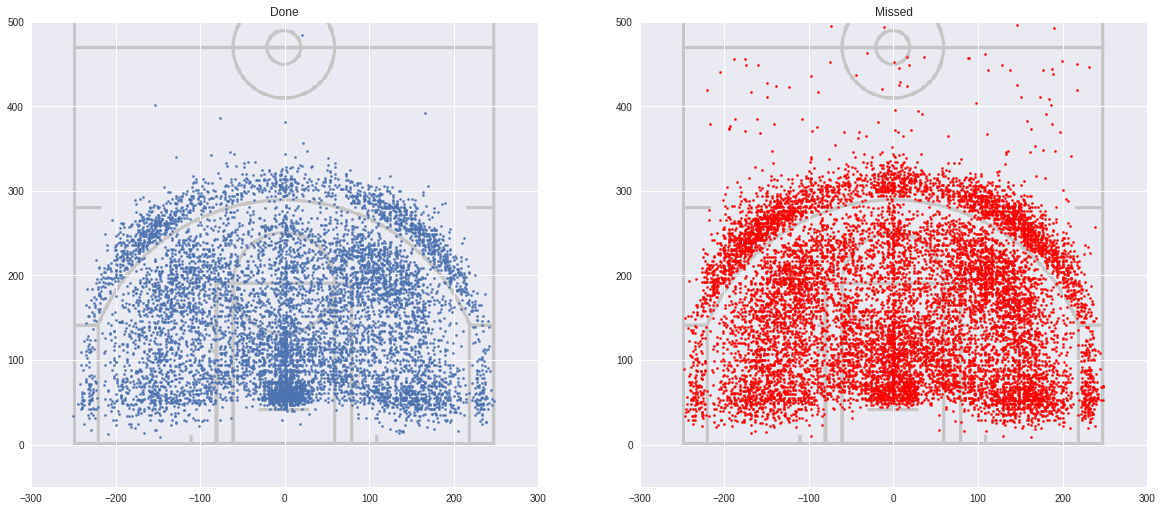

In [48]:
# http://savvastjortjoglou.com/nba-play-by-play-movements.html
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
court = plt.imread(folder + "fullcourt.png")
court = np.transpose(court, (1, 0, 2))

ax1.imshow(court, zorder=0, extent=[-250, 250, 0, 940])
ax1.scatter(data['loc_x'][data['shot_made_flag'] == 1], data['loc_y'][data['shot_made_flag'] == 1] + 52.5, s=5)
ax1.set(xlim=[-300, 300], ylim=[-50, 500], aspect=1)
ax1.set_title('Done')

ax2.imshow(court, zorder=0, extent=[-250, 250, 0, 940])
ax2.scatter(data['loc_x'][data['shot_made_flag'] == 0], data['loc_y'][data['shot_made_flag'] == 0] + 52.5, s=5, color='red')
ax2.set(xlim=[-300, 300], ylim=[-50, 500], aspect=1)
ax2.set_title('Missed')

f.gca().set_aspect('equal')
f.subplots_adjust(hspace=0)
plt.show()

We drop columns with redundant location information:

* `lat, lon`
* `shot_zone_area`
* `shot_zone_range`
* `shot_zone_basic`
* `shot_distance`

They can all be represented more precisely with `[loc_x, loc_y]`. We will only keep the additional information of whether it was a 2PT or 3PT shot to account for hard to quantify psycological factors affecting the accuracy.

We also delete other redundant columns and those that do not offer relevant information for the purpose of model building (`['game_id', 'game_event_id', 'shot_id']`)

In [49]:
data.loc_x.min()

-250

In [50]:
drop_columns = ['game_id', 'game_event_id', 'team_id', 'team_name', 'lat', 'lon', 'shot_zone_area', 
                'shot_zone_range', 'shot_zone_basic', 'shot_distance', 'shot_id']
data.drop(drop_columns, axis=1, inplace=True)

In [51]:
data['3PT shot'] = data.shot_type.str[0] == '3'
data.drop('shot_type', axis=1, inplace=True)

# Exploratory analysis and feature selection

Here we will plot some features to recognize which ones we should consider when builing a classification model for Kobe's shots.

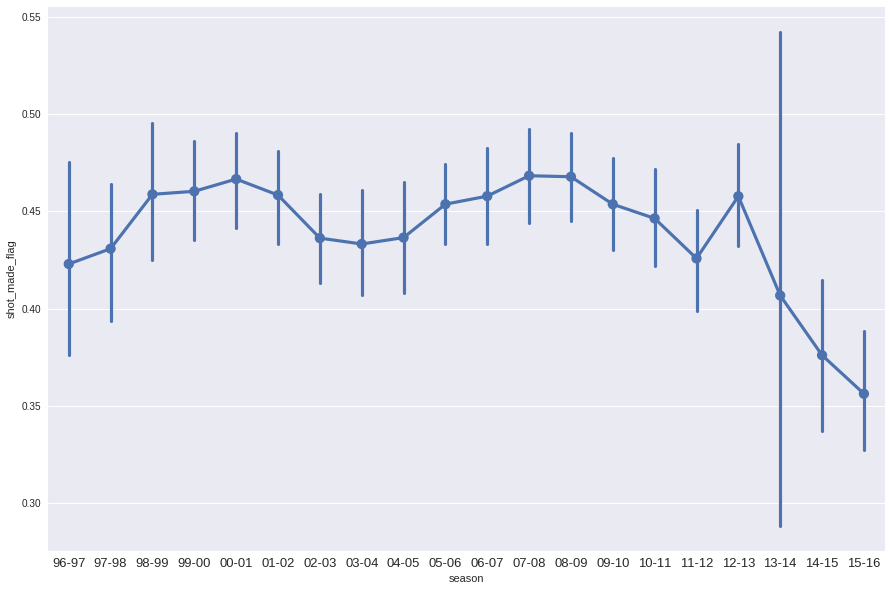

In [52]:
plt.figure(figsize=(15, 10))
ax = sns.pointplot(x='season', y='shot_made_flag', data=data, order=sorted(list(data['season'].unique())))
ax.set_xticklabels([x[2:] for x in sorted(list(data['season'].unique()))], fontsize=13)
plt.show()

The effectivity shows a very clear dependecy respect to the season. This means that the season will be a relevant feature for modelling. The big error bar for season 13-14 is due to the low number of shots Kobe took that year: he was injured during most of the season.

Let's now look at the type of shot. First we count how many shots he took of each type. The dataset has two columns with this information: `action_type` and `combined_shot_type`.

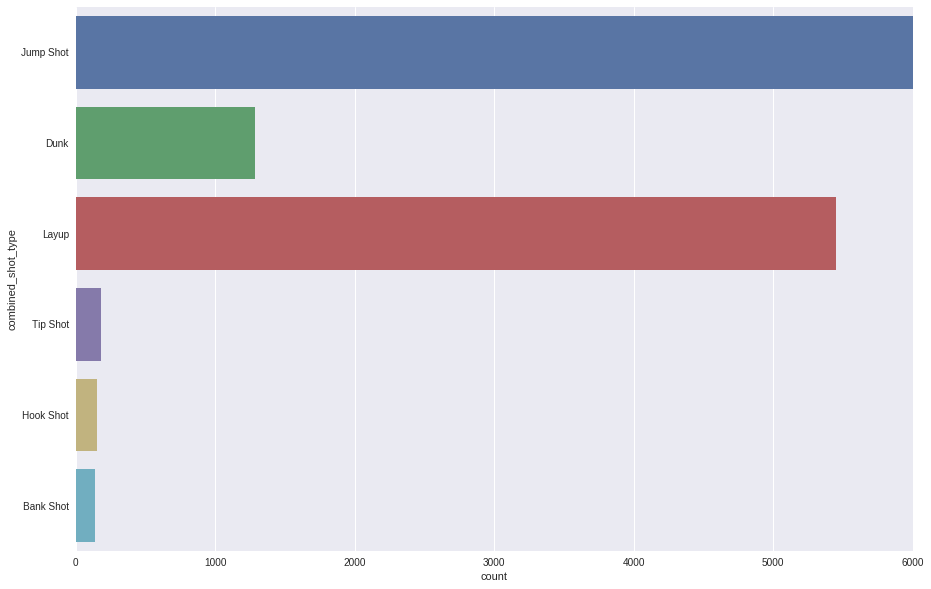

In [53]:
plt.figure(figsize=(15, 10))
sns.countplot(y='combined_shot_type', data=data)
plt.xlim(0, 6000)
plt.show()

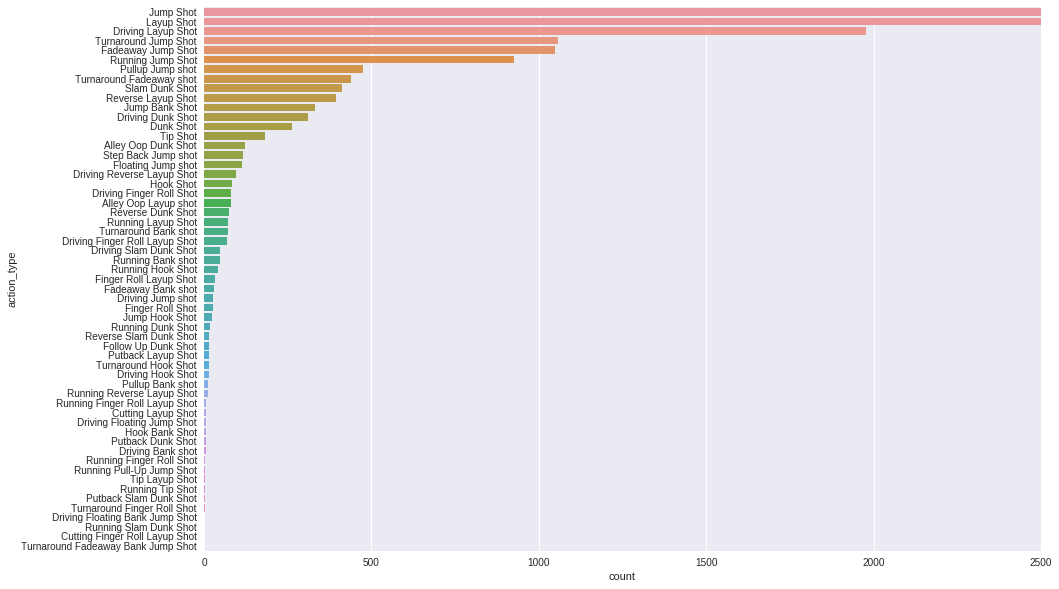

In [54]:
plt.figure(figsize=(15, 10))
sns.countplot(y='action_type', data=data, order=data['action_type'].value_counts().index)
plt.xlim(0, 2500)
plt.show()

Seems like `action_type` has a lot more information than `combined_shot_type`, because of the greater number of shot types. To avoid information redundancy, we will try to work only with `action_type` then.

Shots that were seldom used by Kobe will have no predictive value whatsover. We decide then to replace all `action_type` values with less than 100 occurrencies by the name `Other`.

In [55]:
data.loc[data.groupby('action_type').action_type.transform('count').lt(100), 'action_type'] = 'Other'    

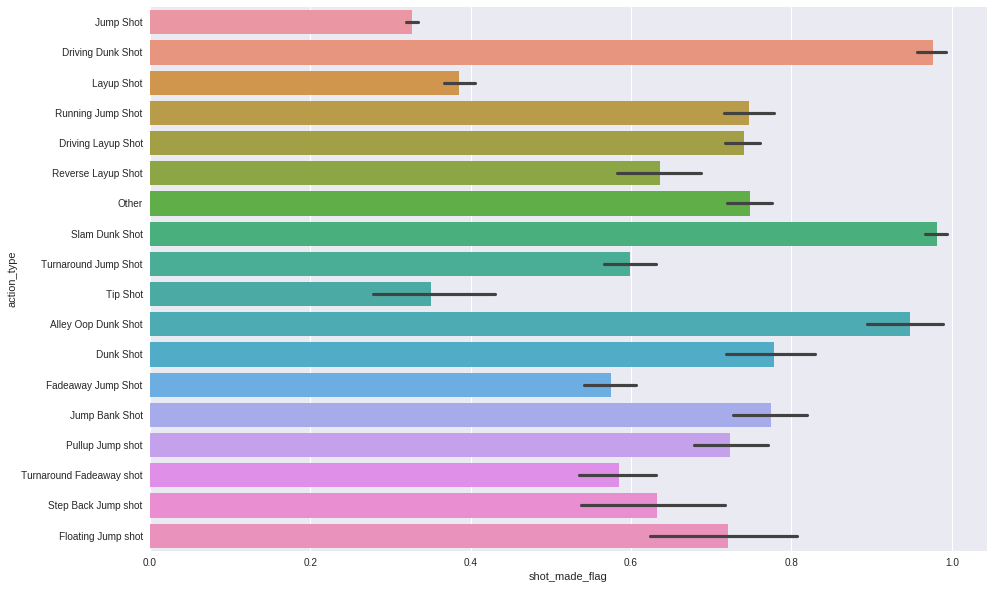

In [56]:
plt.figure(figsize=(15, 10))
sns.barplot(y='action_type', x='shot_made_flag', data=data)

This already looks useful. Every kind of shot seems to have a distinct effectivity, and therefore `action_type` will be an adequate feature for our model. We can now safely disregard `combined_shot_type`

In [57]:
data.drop('combined_shot_type', axis=1, inplace=True)

We only keep month information as the specific game date is not relevant

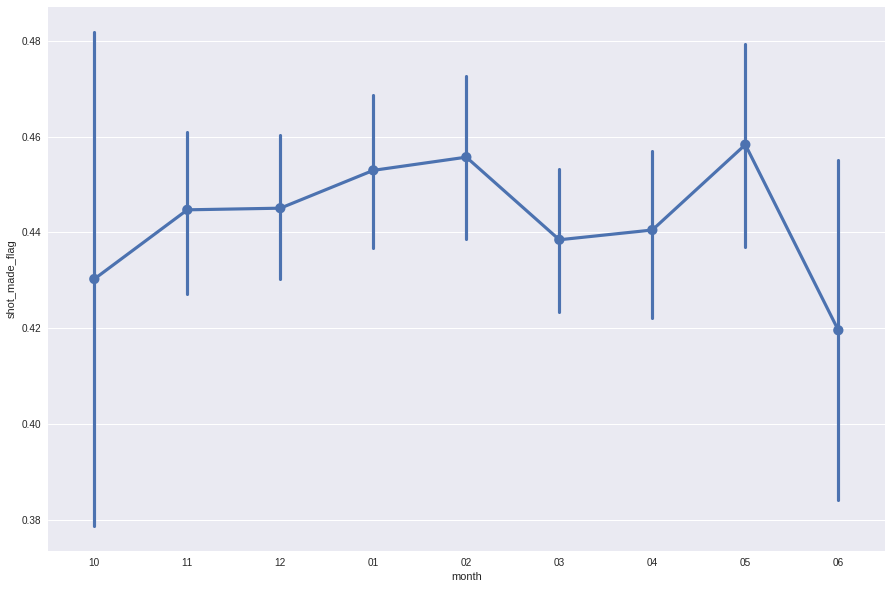

In [58]:
data['month'] = data['game_date'].str[5:7]
data.drop('game_date', axis=1, inplace=True) 

initialSeason = data.season.str[:4].astype(int).min()
data.season = data.season.str[:4].astype(int) - initialSeason

sns.pointplot(x='month', y='shot_made_flag', data=data, order=['10', '11', '12', '01', '02', '03', '04', '05', '06'])
plt.show()

<Figure size 1080x720 with 0 Axes>

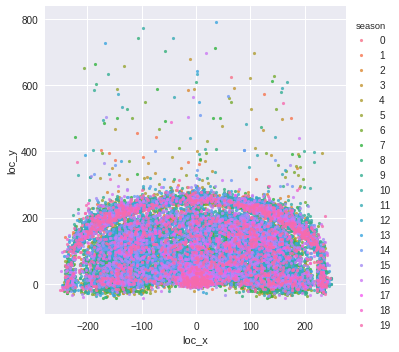

In [67]:
plt.figure(figsize=(15, 10))
sns.lmplot(x='loc_x', y='loc_y', data=data, hue='season', fit_reg=False, 
           scatter_kws={"marker": "D", "s": 10})
plt.show()

`minutes_remaining` and `seconds_remaining` can be merged into a single feature that we will call `time_remaining` and we will measure in seconds

In [16]:
data['time_remaining'] = data.minutes_remaining*60 + data.seconds_remaining
data.drop(['minutes_remaining', 'seconds_remaining'], axis=1, inplace=True)

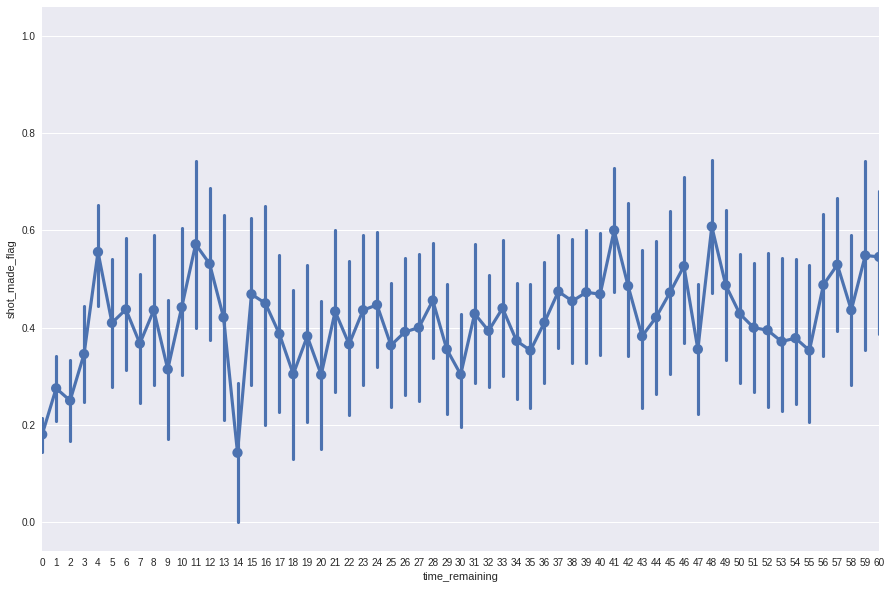

In [17]:
plt.figure(figsize=(15, 10))
ax = sns.pointplot(x='time_remaining', y='shot_made_flag', data=data)
ax.set_xlim(0, 60)
plt.show()

We see the effectivity is fairly constant except for the last minute shots. In order to keep this information while still reducing the number of features, we discretize `time_remaining` in `0, 1, 2, 3, 4`, where `4` also includes all shots taken with more than 4 seconds remaining on the clock.

In [18]:
data.time_remaining.loc[data.time_remaining > 3] = 4

/home/federico/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


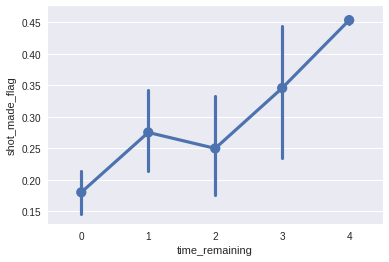

In [19]:
sns.pointplot(x='time_remaining', y='shot_made_flag', data=data)
plt.show()

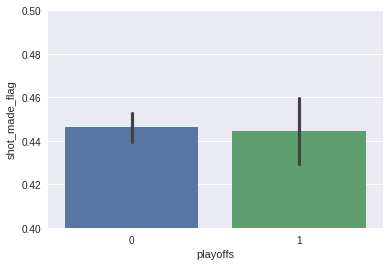

In [20]:
sns.barplot(x='playoffs', y='shot_made_flag', data=data)
plt.ylim(0.4, 0.5)
plt.show()

Whether the game is part of the playoffs phase does not seem to affect Kobe's shot effectivity. We can therefore remove this input feature from the dataset.

In [21]:
data.drop('playoffs', axis=1, inplace=True)

We simplify game location and opponent information

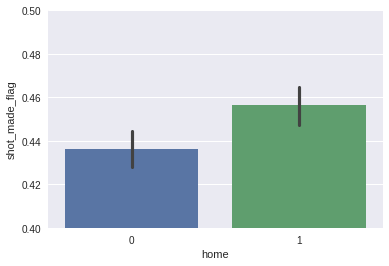

In [22]:
data['home'] = data['matchup'].str.contains('vs').astype(int)
data.drop('matchup', axis=1, inplace=True)

sns.barplot(x='home', y='shot_made_flag', data=data)
plt.ylim(0.4, 0.5)
plt.show()

In contrast to the `playoffs` case, here we see a clear difference between home and away games: Kobe is slightly more effective when at home, and therefore we will keep `home` as a feature.

In [23]:
data.shot_made_flag.isnull().sum()

5000

We don't know the outcome of 5000 shots, so we'll delete those rows

In [24]:
data = data[~data.shot_made_flag.isnull()]

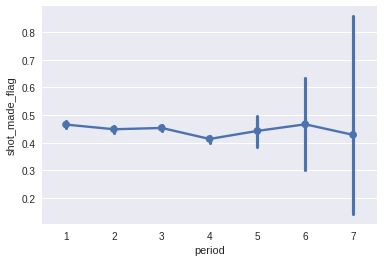

In [25]:
sns.pointplot(x='period', y='shot_made_flag', data=data, scale=0.75)
plt.show()

The big error bars are due to the low number of shots taken from overtime periods. Let's merge them into a single period datapoint. 

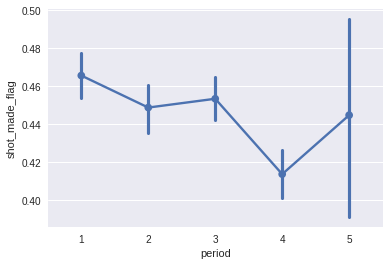

In [26]:
data.period.loc[data.period > 4] = 5
sns.pointplot(x='period', y='shot_made_flag', data=data, scale=0.75)
plt.show()

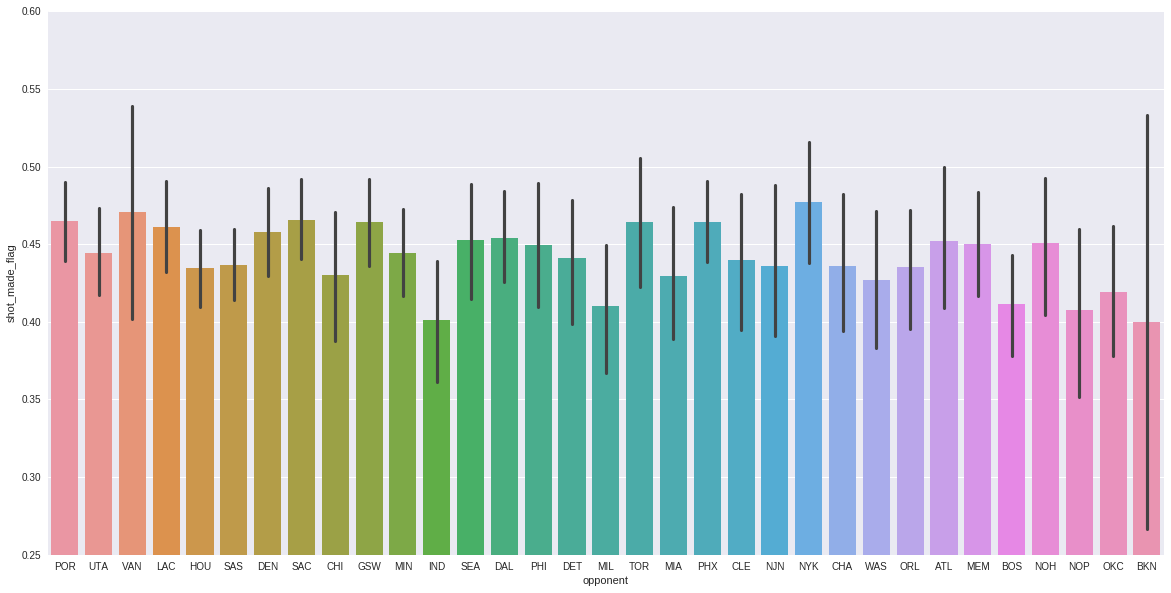

In [27]:
plt.figure(figsize=(20, 10))
sns.barplot(x='opponent', y='shot_made_flag', data=data)
plt.ylim(0.25, 0.6)
plt.show()

There seems to be slight variations on Kobe's performance against the different teams. We will keep this information for now.

The polar coordinate system offers a more natural representation for the shot location in cartesian coordinates. It will likely lead to a more robust model. Let's transform the coordiantes then.

In [28]:
data['distance'] = np.sqrt(data.loc_x**2 + data.loc_y**2)
data['angle'] = np.arctan(data.loc_x/data.loc_y)
data['angle'].fillna(0, inplace=True)

/home/federico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arctan
  


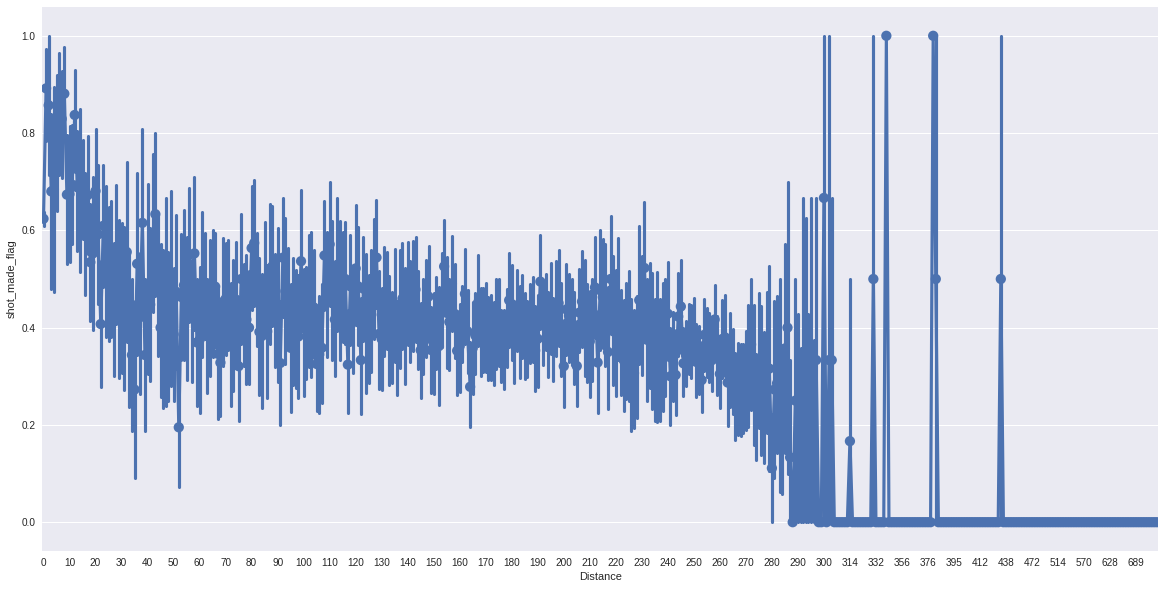

In [29]:
fig = plt.figure(figsize=(20, 10))
sns.pointplot(x=data.distance.astype(int), y='shot_made_flag', data=data)

# Overlapping labels fix
labels = fig.gca().get_xticklabels() # get x labels
for i,l in enumerate(labels):
    if(i%10 != 0): 
        labels[i] = ''
fig.gca().set_xticklabels(labels)

plt.xlabel('Distance')
plt.show()

The signal here is very noisy, but if we take a moving average, we see the effectivity peaks at distances closest to the basket and then there is a plateau that transitions into a slow decrease for shots taken far from the basket.

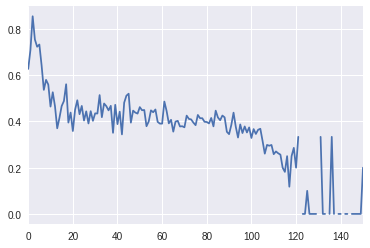

In [30]:
data['distance_binned'] = pd.cut(data.distance, data.distance.max()/2.5)

plt.plot(data.groupby('distance_binned').shot_made_flag.mean().reset_index().shot_made_flag)
plt.xlim(0, 150)
plt.show()

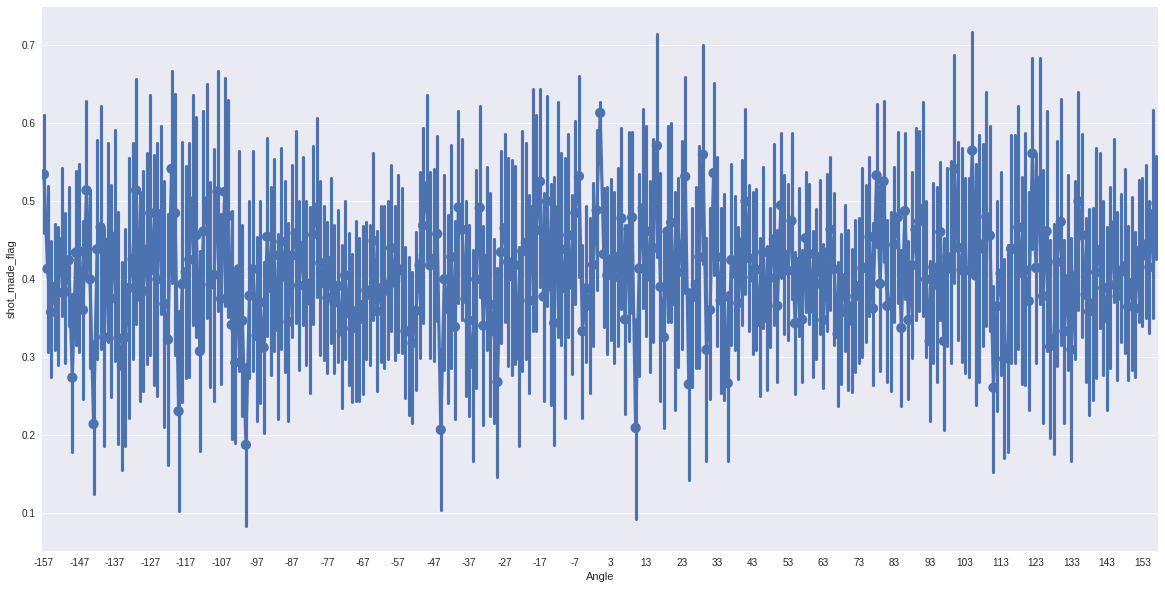

In [31]:
fig = plt.figure(figsize=(20, 10))
sns.pointplot(x=(100*data.angle).astype(int), y='shot_made_flag', data=data)

# Overlapping labels fix
labels = fig.gca().get_xticklabels() # get x labels
for i,l in enumerate(labels):
    if(i%10 != 0): 
        labels[i] = ''
fig.gca().set_xticklabels(labels)

plt.xlabel('Angle')
plt.show()

In [32]:
data.sample(10)

,action_type,loc_x,loc_y,period,season,shot_made_flag,opponent,3PT shot,month,time_remaining,home,distance,angle,distance_binned
18204,Turnaround Fadeaway shot,-51,83,1,15,0.0,HOU,False,01,4,1,97.416631,-0.550982,"(95.219, 97.724]"
19595,Jump Shot,228,0,3,16,0.0,BKN,True,11,4,1,228.000000,1.570796,"(225.518, 228.024]"
6043,Layup Shot,0,0,4,7,0.0,HOU,False,04,4,1,0.000000,0.000000,"(-0.792, 2.506]"
4148,Jump Shot,-233,54,4,6,0.0,IND,True,02,4,0,239.175668,-1.343057,"(238.047, 240.553]"
15241,Fadeaway Jump Shot,67,26,1,13,1.0,MIA,False,12,4,1,71.867934,1.200625,"(70.161, 72.667]"
4376,Jump Shot,144,107,1,6,0.0,POR,False,02,4,1,179.401784,0.931754,"(177.909, 180.414]"
805,Jump Shot,11,241,1,4,0.0,UTA,True,01,4,0,241.250907,0.045611,"(240.553, 243.058]"
28556,Turnaround Jump Shot,176,12,4,12,0.0,UTA,False,04,4,0,176.408617,1.502720,"(175.403, 177.909]"
9953,Jump Shot,138,227,4,10,0.0,LAC,True,12,4,0,265.655792,0.546230,"(265.61, 268.116]"
26128,Running Jump Shot,-6,128,2,3,1.0,SAC,False,04,4,1,128.140548,-0.046841,"(127.794, 130.299]"


colormap en función de la temporada
https://stats.nba.com/media/img/fullcourt.svg
http://savvastjortjoglou.com/nba-play-by-play-movements.html
http://savvastjortjoglou.com/nba-shot-sharts.html